In [117]:
from firedrake import *
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [118]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)

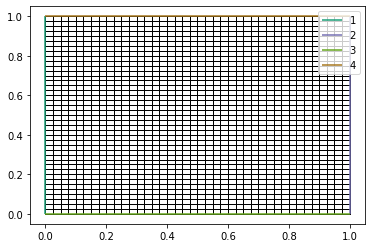

In [119]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

In [120]:
V = FunctionSpace(mesh, "DQ", 1)
W = VectorFunctionSpace(mesh, "CG", 1)

In [121]:
x, y = SpatialCoordinate(mesh)

velocity = as_vector((0.5 - y, x - 0.5))
u = Function(W).interpolate(velocity)


In [122]:
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)

In [123]:
q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

In [124]:
qs = []

In [125]:
T = 2*math.pi
dt = T/2400
dtc = Constant(dt)
q_in = Constant(1.0)

In [126]:
dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

In [127]:
n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

In [128]:
L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)

In [129]:
q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})

In [130]:
dq = Function(V)

In [131]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)

In [132]:
limiter = VertexBasedLimiter(V)

In [133]:
t = 0.0
step = 0
output_freq = 20

In [134]:
limiter.apply(q)

In [135]:
if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)
print(q.dat.data.max())
while t < T - 0.5*dt:
    solv1.solve()
    q1.assign(q + dq)
    limiter.apply(q1)

    solv2.solve()
    q1.assign(q1+dq)
    limiter.apply(q1)
    q2.assign(0.75*q + 0.25*(q1))
    limiter.apply(q2)

    solv3.solve()
    q2.assign(q2+dq)
    limiter.apply(q2)
    q.assign((1.0/3.0)*q + (2.0/3.0)*q2)
    limiter.apply(q)
    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)

t= 0.0
2.0
2.009544084368971
2.0146957744112077
2.0171640339893124
2.0183772699195335
2.019649343581038
2.0220868078440586
2.023906325365653
2.02507938172848
2.027748678896933
2.0303200858288335
2.0319913754421886
2.0327822370894686
2.033324123793679
2.0333944006969276
2.033252110655811
2.0332717215329206
2.0333638487591603
2.0331537659500465
2.0333350890893263
2.0331602440232586
t= 0.052359877559829855
2.033277556687624
2.033327131470568
2.033002326576849
2.033220749430076
2.0333266135980073
2.0331509181178142
2.032753199304889
2.0330981767693115
2.0332473784906955
2.034040157741388
2.0358520730516916
2.037359326719437
2.038420012307022
2.0389925747352713
2.03993297212215
2.040211102695329
2.0397476042002616
2.039510090743424
2.0398340096657246
2.039530470486532
t= 0.1047197551196598
2.039021532203828
2.039587592742633
2.039653350277104
2.0391786556474853
2.03885333406905
2.0394441992063648
2.03962965548238
2.0393771879476814
2.0386613425410087
2.0387529329630176
2.0393142099246773
2.

In [136]:
L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

0.10352009194998309


In [137]:
nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

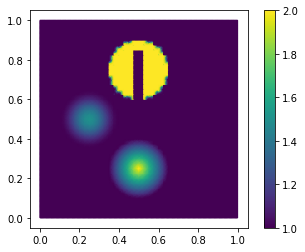

In [138]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)

In [139]:
def animate(q):
    colors.set_array(fn_plotter(q))

In [140]:
interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)
try:
    animation.save("DG_advection_limiter_UROP2.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")